# COMP41680 - Ryan Jennings 19205824

This project takes a name of an Actor e.g. __Nicolas Cage__ or __Halle Berry__, and gathers the information for all their acting credits from **IMDB** before plotting the information and making predictions about their upcoming movies.

In [266]:
import csv
import json
import re

from typing import Any, Dict, List, Union

import requests
import seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from PIL import Image
from sklearn.linear_model import LinearRegression

# Use
seaborn.set()

JsonType = Dict[str, Any]

<span style='color: red'>**API Chosen:**</span>

For this project I made use of 2 APIs and scraping 1 webpage.  
The first API I used was the IMDB suggestions API which seems to be the only publically available API they provide now which made this project a little difficult.  
The endpoint for this API was `https://sg.media-imdb.com/suggests/{first letter}/{search}.json`. It simply returns the search suggestions as you would get if you went to their home page and searched for an actor or show. See the example for searching __Nicolas Cage__ here: `https://sg.media-imdb.com/suggests/n/nicolas%20cage.json`.  

I used the suggestions API to get their IMDB actor Id. I used that Id find their unique webpage on IMDB. Then since IMDB didn't provide an API I had to scrape their webpage to find all the tv show and movie Ids that the actor has starred in (sorry IMDB system engineers I limited my time spent scraping as much as possible).  

When I had a list of all the IMDB tv show and movie Ids for a given actor I could make use of the main API.
The main API was `OMDB` which provides an API to the IMDB database for movies and tv shows based on a movie/tv Id. Their website with documentation and examples can be found here: `http://www.omdbapi.com/`.  I used this API to get as much information as possible about a movie/tv show to be used for later analysis.

The API key I used for OMDB was `7bab4d15`

I picked Nicolas for this project to do the analysis for but after reviewing all the content why not try it with your favourite actor? Simple change the `ACTOR_NAME` variable to you desired actor and continue through each section

In [3]:
OMDB_API_KEY: str = '7bab4d15'

In [4]:
ACTOR_NAME: str = 'Nicolas Cage'

In [7]:
def get_actor_imdb_info(name: str) -> JsonType:
    """
    For a given actor name return their IMDB data consisting of Name, Id and Image URL

    Keyword arguments:
    name: str - Name of actor that will be searched for on IMBD.com
    
    Returns: Jsontype - json data from imdb search
    """
    search_name: str = ''.join(name.split(' ')).lower()
    imdb_suggestions_url: str = f"https://sg.media-imdb.com/suggests/{name[0].lower()}/{search_name}.json"
    res = requests.get(imdb_suggestions_url)
    valid_json_str: str = res.text[(5 + len(name)):-1]
    json_data: JsonType = json.loads(valid_json_str)['d'][0]
    return json_data

def get_actors_credits_by_imdb_id(act_id: str) -> List[str]:
    """
    Returns a list of Ids of the Actors acting credits from IMDB

    Keyword arguments:
    act_id: str - Actor's IMDB Id

    Returns: List[str] - List of IMDB Ids of Actor's acting credits
    """
    film_ids: List[str] = []
    actor_url: str = f"https://www.imdb.com/name/{act_id}"
    actor_page = requests.get(actor_url)
    html_soup: BeautifulSoup = BeautifulSoup(actor_page.text, 'html.parser')
    films = html_soup.find_all('div', class_='filmo-category-section')
    links = films[0].find_all('a')
    for link in links:
        if link.has_attr('href') and link.attrs['href'].startswith('/title'):
            film_ids.append(link.attrs['href'].split('/')[2])
    return film_ids

def get_actor_image(actor_data: JsonType) -> Image:
    """
    Retrieve an image object of an Actor from IMDB

    Keyword arguments:
    actor_data: JsonType - Actor json data from IMDB suggestion

    Return: PIL.Image.Image - Python Imaging Library Image object for Actor
    """
    actor_img_url: str = actor_data['i'][0]
    im = Image.open(requests.get(actor_img_url, stream=True).raw)
    return im.resize((actor_data['i'][1]//5, actor_data['i'][2]//5), Image.ANTIALIAS)

In [9]:
actor_data: str = get_actor_imdb_info(ACTOR_NAME)
credit_ids: List[str] = get_actors_credits_by_imdb_id(actor_data['id'])
actor_image: Image = get_actor_image(actor_data=actor_data)

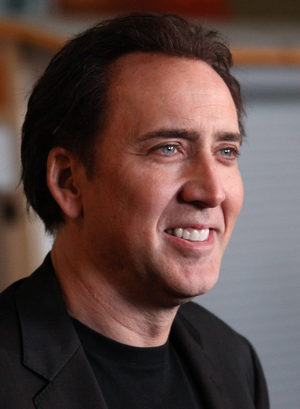

In [10]:
actor_image

The free version of the OMDB Api has a limit of **1000 calls a day**. Even the most prolific of famous actors such as Nicolas Cage (103), Michael Madsen (307), Better Midler (114), etc. don't come close to the 1000 a day limit.  
Although if anybody is interesting in viewing data about Mel Blanc (1149) or Mark Wood (1748) or other power-actors then functionality is provided to continue on over multiple days to build up the dataset.

In [146]:
def retrieve_credit_data_by_id(show_id: str) -> JsonType:
    """
    Movie data by imdb id

    keyword arguments:
    show_id: str - imdb id value for a movie/tv show

    Return: JsonType - JSON data from the API
    """
    omdb_url: str = f"http://www.omdbapi.com/?apikey={OMDB_API_KEY}&i={show_id}"
    return requests.get(omdb_url).json()

In [172]:
credits: List[JsonType] = []
CHECKPOINT: int = 0

In [259]:
def safe_retrieve_credit_data(credit_ids: List[str], checkpoint: int) -> int:
    """
    Retrieve data. If there is an error note the breakpoint
    to continue from in subsequent runs

    There are some Ids that randomly don't work for the OMDB Api
    and return a generic error so need to be filtered out

    Keyword argument:
    credit_ids: List[str] - List of the IMDB Ids for movies and tv shows
    checkpoint: int - The checkpoint number to carry on from

    Return: int - the checkpoint index
    """
    for m_id in credit_ids[checkpoint:]:
        res = retrieve_credit_data_by_id(m_id)
        if 'Limit Reached' in res.get('Error', ''):
            print(res.get('Error'))
            return checkpoint
        if res.get('Title', False):
            credits.append(res)
            checkpoint += 1
    return checkpoint

In [183]:
CHECKPOINT = safe_retrieve_credit_data(credit_ids=credit_ids, checkpoint=CHECKPOINT)

#### Structure of API responses
Example of a single credit and how it looks can be seen in the cell below.  Some of the fields will be useful for data analysis such as `imdbRating` and `Year`, some of the other fields will have to be filtered away as they don't provide interesting information for analysis such as `Plot` and the `Poster` link.

In [14]:
credits[-1]

{'Title': 'Best of Times',
 'Year': '1981',
 'Rated': 'N/A',
 'Released': 'N/A',
 'Runtime': '95 min',
 'Genre': 'Comedy',
 'Director': 'Don Mischer',
 'Writer': 'Bob Arnott, Carol Hatfield, Lane Sarasohn',
 'Actors': 'Crispin Glover, Jill Schoelen, Nicolas Cage, Julie Piekarski',
 'Plot': "Here's the lives of 7 teenage friends in 1981, singing, dancing and breaking the 4th wall.",
 'Language': 'English',
 'Country': 'USA',
 'Awards': 'N/A',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BNjZlYTFiMzgtZWYwMS00OTExLWI3YmQtYTc5YzlmYzJiMTI0XkEyXkFqcGdeQXVyMzU0NzkwMDg@._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '5.5/10'}],
 'Metascore': 'N/A',
 'imdbRating': '5.5',
 'imdbVotes': '197',
 'imdbID': 'tt0082064',
 'Type': 'movie',
 'DVD': 'N/A',
 'BoxOffice': 'N/A',
 'Production': 'N/A',
 'Website': 'N/A',
 'Response': 'True'}

In [147]:
def write_credits_data_to_csv(credits: JsonType) -> None:
    """
    Convert movie data from json to csv and write to file

    Keyword arguments:
    credits: JsonType - JSON data from the OMDB API

    Return: None
    """
    with open('credits_data.csv', 'w') as credits_file:
        csv_writer = csv.DictWriter(credits_file, fieldnames=list(credits[0].keys()), delimiter=',')
        csv_writer.writeheader()
        for credit in credits:
            csv_writer.writerow(credit)

In [16]:
write_credits_data_to_csv(credits=credits)

## Analysing the Data

In [225]:
# Read csv file into pandas dataframe
credits = pd.read_csv('credits_data.csv')

In [226]:
num_instances, num_attributes = credits.shape
print(f"Number of instances: {num_instances}\nNumber of attributes: {num_attributes}")

Number of instances: 102
Number of attributes: 25


In [227]:
pd.set_option('display.max_columns', 100)
credits.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,10 Double Zero,2017,NaN,NaN,NaN,Crime,Christian Sesma,"Christian Sesma, Paul Sloan, Nick Vallelonga",NaN,DET. DANA REEVES is infamous for crossing the ...,English,USA,NaN,NaN,[],NaN,NaN,NaN,tt5843576,movie,NaN,NaN,NaN,NaN,True
1,The Croods 2,2020,NaN,23 Dec 2020,NaN,"Animation, Adventure, Comedy, Family, Fantasy",Joel Crawford,"Kirk DeMicco (creator), Dan Hageman (screenpla...","Nicolas Cage, Ryan Reynolds, Emma Stone, Kat D...",The prehistoric family the Croods are challeng...,English,USA,NaN,https://m.media-amazon.com/images/M/MV5BNTc1M2...,[],NaN,NaN,NaN,tt2850386,movie,NaN,NaN,20th Century Fox,NaN,True
2,Pig,2020,NaN,NaN,NaN,Drama,Michael Sarnoski,"Vanessa Block, Michael Sarnoski, Michael Sarnoski","Nicolas Cage, Alex Wolff, Adam Arkin, Nina Bel...",A truffle hunter who lives alone in the Oregon...,English,USA,NaN,NaN,[],NaN,NaN,NaN,tt11003218,movie,NaN,NaN,NaN,NaN,True
3,Prisoners of the Ghostland,2020,NaN,NaN,NaN,"Action, Horror, Thriller",Sion Sono,"Aaron Hendry, Reza Sixo Safai (screenplay)","Nicolas Cage, Sofia Boutella, Ed Skrein, Teres...",A notorious criminal must break an evil curse ...,English,"Japan, USA",NaN,https://m.media-amazon.com/images/M/MV5BNWQ0NT...,[],NaN,NaN,NaN,tt6372694,movie,NaN,NaN,NaN,NaN,True
4,Jiu Jitsu,2020,NaN,09 Jul 2020,NaN,"Action, Fantasy",Dimitri Logothetis,"Dimitri Logothetis (Writer), Jim McGrath (Writer)","Nicolas Cage, Marie Avgeropoulos, Frank Grillo...",A new Sci-Fi Martial Arts franchise from Dimit...,NaN,USA,NaN,https://m.media-amazon.com/images/M/MV5BYjFlMG...,[],NaN,NaN,NaN,tt9624766,movie,NaN,NaN,NaN,NaN,True


### Sanitising the Data
First of all some of the columns are not needed or provide useless information. Other columns need the data to be parsed and converted to a suitable format such as removing `min` after each number for the `Runtime` colour

Drop non-useful columns from the dataset.  
Drop:
- Genre
- Actors
- Writer
- Plot
- Language
- Country
- Awards
- Poster
- Ratings
- imdbID
- Type
- DVD
- Response
- Website

In [242]:
credits = credits.drop(['Genre', 'Writer', 'Actors',
                        'Plot', 'Language', 'Country',
                        'Awards', 'Poster', 'Ratings',
                        'imdbID', 'Type', 'DVD',
                        'Website', 'Response'], axis=1)

Clean up `Runtime`, `imdbVotes` and `BoxOffice` columns from strings to appropriate floats

In [244]:
credits['Runtime'] = credits['Runtime'].apply(lambda x: float(x.replace(' min', '')) if type(x) == str else x)

In [245]:
credits['imdbVotes'] = credits['imdbVotes'].apply(lambda x: float(x.replace(',', '')) if type(x) != float and ',' in x else float(x))

In [257]:
credits['BoxOffice'] = credits['BoxOffice'].apply(lambda x: float(re.sub('\$|,', '', x)) if type(x) != float else x)

In [247]:
rating_map: Dict[str, Union[int, float]] = {
    'Not Rated': np.nan,
    'PG': 0,
    'PG-13': 1,
    'R': 2,
    'Unrated': 2,
    'TV-MA': 3,
    'NC-17': 3
}

In [248]:
credits = credits.replace({'Rated': rating_map})

An example of what the data looks like now it has been cleaned.  I have reversed the dataframe just so good example values can be seen. From the newest back there are a lot of NaN as the movies are yet to be released

In [263]:
credits[::-1].head()

,Title,Year,Rated,Released,Runtime,Director,Metascore,imdbRating,imdbVotes,BoxOffice,Production
101,Best of Times,1981,NaN,NaN,95.0,Don Mischer,NaN,5.5,197.0,NaN,NaN
100,Fast Times at Ridgemont High,1982,2,13 Aug 1982,90.0,Amy Heckerling,67.0,7.2,88281.0,NaN,Universal Pictures
99,Valley Girl,1983,2,29 Apr 1983,99.0,Martha Coolidge,66.0,6.4,12171.0,NaN,MGM Home Entertainment
98,Rumble Fish,1983,2,21 Oct 1983,94.0,Francis Ford Coppola,63.0,7.2,30114.0,NaN,Universal Pictures
97,Racing with the Moon,1984,0,23 Mar 1984,108.0,Richard Benjamin,NaN,6.7,3853.0,NaN,Paramount Home Video


## What does the data look like?

In [252]:
# Plot Year by Rating
# Plot Runtime by Rating
# Plot Rated by Rating (boxplot?)
# Plot Rated by Runtime (boxplot?)
# Plot Metascore by imdb Rating * 10 (see how well a straight line they correlate with a line of best fit)
# Plot Year by Boxoffice
# Plot Rating by Boxoffice
# Plot Rating by Production Company
# Joy plot

In [258]:
credits.describe(include='all')

,Title,Year,Rated,Released,Runtime,Director,Metascore,imdbRating,imdbVotes,BoxOffice,Production
count,102,102.000000,87.0,97,97.000000,102,77.000000,97.000000,97.000000,3.300000e+01,88
unique,102,NaN,4.0,97,NaN,88,NaN,NaN,NaN,NaN,54
top,Outcast,NaN,2.0,22 Dec 2000,NaN,Paul Schrader,NaN,NaN,NaN,NaN,Sony Pictures Home Entertainment
freq,1,NaN,53.0,1,NaN,3,NaN,NaN,NaN,NaN,6
mean,NaN,2004.990196,NaN,NaN,105.164948,NaN,49.883117,5.944330,69495.814433,4.663337e+07,NaN
std,NaN,11.724980,NaN,NaN,17.447947,NaN,18.475428,1.077127,94173.700043,5.764736e+07,NaN
min,NaN,1981.000000,NaN,NaN,50.000000,NaN,12.000000,3.100000,20.000000,4.526000e+03,NaN
25%,NaN,1995.000000,NaN,NaN,95.000000,NaN,35.000000,5.200000,6217.000000,1.070679e+07,NaN
50%,NaN,2007.000000,NaN,NaN,101.000000,NaN,48.000000,6.000000,31559.000000,2.403304e+07,NaN
75%,NaN,2016.000000,NaN,NaN,116.000000,NaN,66.000000,6.800000,91935.000000,6.314381e+07,NaN


In [255]:
credits.corr(method='pearson')

,Year,Runtime,Metascore,imdbRating,imdbVotes
Year,1.000000,-0.055867,-0.386582,-0.317142,0.003595
Runtime,-0.055867,1.000000,0.290068,0.386817,0.506032
Metascore,-0.386582,0.290068,1.000000,0.755419,0.280595
imdbRating,-0.317142,0.386817,0.755419,1.000000,0.535331
imdbVotes,0.003595,0.506032,0.280595,0.535331,1.000000


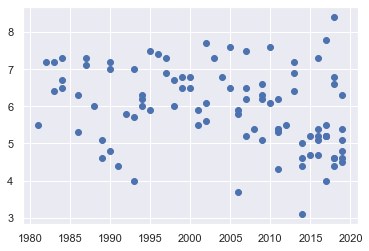

In [267]:
plt.scatter(credits['Year'], credits['imdbRating'])

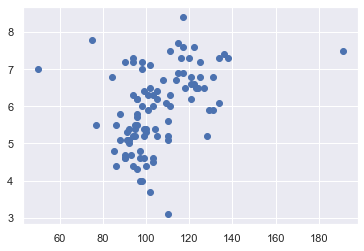

In [268]:
plt.scatter(credits['Runtime'], credits['imdbRating'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b624290>,
      dtype=object)

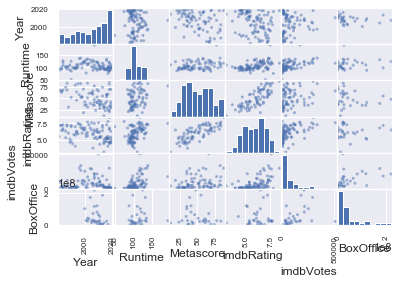

In [269]:
pd.plotting.scatter_matrix(credits)

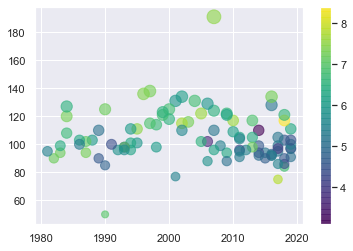

In [270]:
plt.scatter(credits['Year'], credits['Runtime'], s=credits['Runtime'], c=credits['imdbRating'], alpha=0.6, cmap='viridis')
plt.colorbar()

In [86]:
credits[((credits['imdbRating']*10 + credits['Metascore'])/2) > 75]['Title']

11    Spider-Man: Into the Spider-Verse
52                           Grindhouse
61                          Adaptation.
72                             Face/Off
75                    Leaving Las Vegas
91                           Moonstruck
Name: Title, dtype: object

## Analysis

In [32]:
# Apply a Linear Regression onto value to plot the line of best fit
# Try to predict how good his upcoming movies will do based on info about them

In [271]:
ratings = credits.dropna(subset=['imdbRating'], inplace=False)

In [272]:
model = LinearRegression()
years2D = ratings['Year'][:, np.newaxis][::-1]
print(years2D.shape)

(97, 1)


In [273]:
rates = list(ratings['imdbRating'])
model.fit(years2D, rates)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

(0, 10)

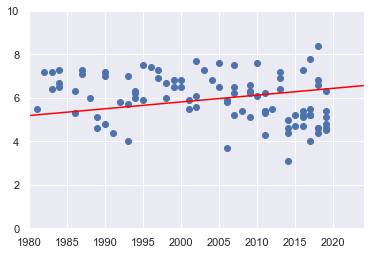

In [274]:
xfit = np.linspace(1980, 2024)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(list(ratings['Year']), rates)
plt.plot(xfit, yfit, color='red')
ax = plt.gca()
ax.set_xlim([1980, 2024])
ax.set_ylim([0, 10])

In [47]:
model.intercept_

2024.4460837853348

In [79]:
model.coef_

array([0.03133381])